<a href="https://colab.research.google.com/github/bw-spotify2/ds/blob/master/Song_Selector_Model_Building.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

df = pd.read_csv('/content/drive/My Drive/Lambda/Unit 4/Sprint 4/SpotifyFeatures.csv')
df.sample(10)

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
178977,Jazz,Marion Meadows,Step A Little Closer,79Qqdl7pQ5swAb0pscELUi,29,0.596000,0.711,235253,0.788,0.090900,A,0.0811,-6.711,Minor,0.0444,89.998,4/4,0.726
145152,Indie,The Wonder Years,Sister Cities,79pCyoeKNF4Zaa1BYl21AL,50,0.000026,0.255,181000,0.872,0.000130,G,0.0347,-4.371,Major,0.0850,179.780,4/4,0.381
101544,Children’s Music,Smallpools,People Watching,6kNEaRYwAFOVWXNZKljej5,50,0.051500,0.567,219355,0.915,0.000000,G,0.1440,-4.635,Major,0.0542,92.971,4/4,0.486
153314,Rock,Debbie Gibson,Lost in Your Eyes,6PMDILZiYo4YzMBbE0dGK9,63,0.460000,0.482,213000,0.613,0.000856,G,0.1290,-7.462,Major,0.0295,144.460,4/4,0.238
50132,Blues,The Allman Brothers Band,Done Somebody Wrong - Live At The Fillmore Eas...,0WDsLvL9DKjj3qjed4IBa0,36,0.319000,0.490,275304,0.622,0.050500,F,0.9440,-9.982,Major,0.0688,145.408,4/4,0.638
167455,Comedy,Bill Burr,My Theories,6ldL3RYifQfZOVp5nSbCNM,43,0.922000,0.558,229680,0.790,0.000000,C#,0.6940,-9.725,Major,0.9500,86.179,3/4,0.389
134338,Reggae,Jah Cure,Life We Live,7qC8skHtwFEJYEczgFWXik,34,0.110000,0.627,210400,0.795,0.000000,C,0.1100,-2.971,Major,0.0620,155.719,4/4,0.706
213524,Country,Frankie Ballard,You'll Accomp'ny Me,61jWRBNxdM3sO5oKLwZV9y,56,0.024800,0.598,240413,0.753,0.000000,G,0.4100,-5.605,Major,0.0319,107.970,4/4,0.688
25252,Electronic,The Avalanches,Stay Another Season,7kp0pGc7BjSe6aTyWUUQvT,36,0.035000,0.613,139947,0.947,0.000549,C,0.3460,-8.772,Major,0.1900,102.816,4/4,0.372
204534,Soundtrack,Kevin Kiner,Ahsoka’s Fall,6wI5le9tkQTnL4kI5EhPLc,30,0.654000,0.163,113867,0.257,0.939000,E,0.1670,-11.846,Major,0.0377,128.682,4/4,0.045


In [2]:
!pip install spotipy --upgrade
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import time 

client_id = '14f59f665a094868921bdd76e420d7c0'
client_secret = '5e16ddb0f2ed45a69949330bbd34351a'
username = 'mahoryu'

client_credentials_manager = SpotifyClientCredentials(client_id, client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [4]:
def getTrackFeatures(X):
  X = X.copy()

  for i in range(len(X['track_id'])):
    meta = sp.track(X['track_id'][i])
    features = sp.audio_features(X['track_id'][i])

    X['mode'][i] = features[0]['mode']
    X['key'][i] = features[0]['key']
    X['time_signature'][i] = features[0]['time_signature']

    print(f"Finished line {i}.")
  
  return X

In [5]:
df_test = df[:5000]
df_test.shape

(5000, 18)

In [6]:
df_new = getTrackFeatures(df_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


Streaming output truncated to the last 5000 lines.
Finished line 1.
Finished line 2.
Finished line 3.
Finished line 4.
Finished line 5.
Finished line 6.
Finished line 7.
Finished line 8.
Finished line 9.
Finished line 10.
Finished line 11.
Finished line 12.
Finished line 13.
Finished line 14.
Finished line 15.
Finished line 16.
Finished line 17.
Finished line 18.
Finished line 19.
Finished line 20.
Finished line 21.
Finished line 22.
Finished line 23.
Finished line 24.
Finished line 25.
Finished line 26.
Finished line 27.
Finished line 28.
Finished line 29.
Finished line 30.
Finished line 31.
Finished line 32.
Finished line 33.
Finished line 34.
Finished line 35.
Finished line 36.
Finished line 37.
Finished line 38.
Finished line 39.
Finished line 40.
Finished line 41.
Finished line 42.
Finished line 43.
Finished line 44.
Finished line 45.
Finished line 46.
Finished line 47.
Finished line 48.
Finished line 49.
Finished line 50.
Finished line 51.
Finished line 52.
Finished line 53.
Fini

In [90]:
headers = ['popularity','acousticness','danceability','duration_ms','energy','instrumentalness','liveness','loudness','speechiness','tempo','valence']
df_new = df[headers]

In [91]:
df_new.head()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,0,0.611,0.389,99373,0.910,0.000,0.3460,-1.828,0.0525,166.969,0.814
1,1,0.246,0.590,137373,0.737,0.000,0.1510,-5.559,0.0868,174.003,0.816
2,3,0.952,0.663,170267,0.131,0.000,0.1030,-13.879,0.0362,99.488,0.368
3,0,0.703,0.240,152427,0.326,0.000,0.0985,-12.178,0.0395,171.758,0.227
4,4,0.950,0.331,82625,0.225,0.123,0.2020,-21.150,0.0456,140.576,0.390


In [92]:
df_new.shape

(232725, 11)

In [93]:
from keras.models import Model
from keras.layers import Input, Dense
from keras import regularizers
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

In [94]:
# Normalise
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df_new)

In [95]:
df_scaled = pd.DataFrame(data_scaled,columns=headers)
df_scaled.head()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,0.00,0.613454,0.356292,0.015167,0.910909,0.000000,0.339614,0.900856,0.032070,0.642704,0.814
1,0.01,0.246988,0.571934,0.022029,0.737732,0.000000,0.142710,0.834469,0.068374,0.675801,0.816
2,0.03,0.955823,0.650252,0.027969,0.131113,0.000000,0.094241,0.686429,0.014818,0.325182,0.368
3,0.00,0.705823,0.196438,0.024747,0.326313,0.000000,0.089697,0.716695,0.018311,0.665238,0.227
4,0.04,0.953815,0.294067,0.012142,0.225209,0.123123,0.194208,0.557054,0.024767,0.518516,0.390


In [98]:
# Fixed dimensions
input_dim = df_new.shape[1]  # 11

# Number of neurons in each Layer [11, 7, 4, 2, ...] of encoders
input_layer = Input(shape=(input_dim, ))
encoder_layer_1 = Dense(7, activation="relu", activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder_layer_2 = Dense(4, activation="relu")(encoder_layer_1)
encoder_layer_3 = Dense(2, activation="relu")(encoder_layer_2)

# Crear encoder model
encoder = Model(inputs=input_layer, outputs=encoder_layer_3)

decoder_1 = Dense(4, activation='relu')(encoder_layer_3)
decoder_2 = Dense(7, activation='relu')(decoder_1)
decoder_output = Dense(11, activation = 'softmax')(decoder_2)

autoencoder = Model(input_layer, decoder_output)

autoencoder.summary()

Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 11)                0         
_________________________________________________________________
dense_87 (Dense)             (None, 7)                 84        
_________________________________________________________________
dense_88 (Dense)             (None, 4)                 32        
_________________________________________________________________
dense_89 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_90 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_91 (Dense)             (None, 7)                 35        
_________________________________________________________________
dense_92 (Dense)             (None, 11)                88 

In [99]:

autoencoder.compile(optimizer='adam',
                    loss='mean_squared_error',
                    metrics=['accuracy'])

autoencoder.fit(df_scaled, df_scaled,
                epochs=10,
                batch_size=32)
                # shuffle=True,
                # validation_data=(x_test, x_test),
                # verbose = 1,
                # callbacks=[stop, tensorboard])

Epoch 1/10
232725/232725 [==============================] - 34s 146us/step - loss: 0.1274 - accuracy: 0.5637
Epoch 2/10
232725/232725 [==============================] - 34s 145us/step - loss: 0.1238 - accuracy: 0.5919
Epoch 3/10
232725/232725 [==============================] - 35s 149us/step - loss: 0.1236 - accuracy: 0.5892
Epoch 4/10
232725/232725 [==============================] - 35s 149us/step - loss: 0.1236 - accuracy: 0.5864
Epoch 5/10
232725/232725 [==============================] - 33s 143us/step - loss: 0.1236 - accuracy: 0.5863
Epoch 6/10
232725/232725 [==============================] - 33s 144us/step - loss: 0.1235 - accuracy: 0.5838
Epoch 7/10
232725/232725 [==============================] - 33s 144us/step - loss: 0.1235 - accuracy: 0.5856
Epoch 8/10
232725/232725 [==============================] - 34s 146us/step - loss: 0.1235 - accuracy: 0.5867
Epoch 9/10
232725/232725 [==============================] - 33s 141us/step - loss: 0.1235 - accuracy: 0.5875
Epoch 10/10
232725/

In [100]:

# Use the model to predict the factors which sum up the information of interest rates.
encoded_data = pd.DataFrame(encoder.predict(data_scaled))
encoded_data.columns = ['x', 'y']
encoded_data.head()

,x,y
0,5.183822,0.951172
1,5.131352,1.020463
2,3.938922,1.852142
3,4.587314,1.363285
4,3.767715,1.971553


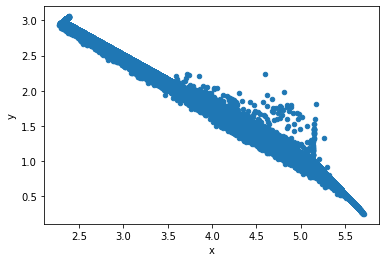

In [101]:
encoded_data.plot.scatter('x','y')

In [102]:
from scipy.spatial import distance
a = (1, 2, 3)
b = (4, 5, 6)
dst = distance.euclidean(a, b)

In [111]:
encoded_data.head()

,x,y
0,5.183822,0.951172
1,5.131352,1.020463
2,3.938922,1.852142
3,4.587314,1.363285
4,3.767715,1.971553


In [124]:
def get_e_dist(x):
  return distance.euclidean(x[[0,1]],(2.939129,1.748975))

In [125]:
# encoded_data['e_distance'] = distance.euclidean(encoded_data[['x','y']],(2.939129,1.748975))
encoded_data['e_distance'] = encoded_data.apply(get_e_dist, axis=1)

In [126]:
encoded_data.head()

,x,y,e_distance
0,5.183822,0.951172,2.382255
1,5.131352,1.020463,2.310102
2,3.938922,1.852142,1.005102
3,4.587314,1.363285,1.692711
4,3.767715,1.971553,0.857960


In [127]:
encoded_data['e_distance'].nsmallest(5)

206737    0.493700
153652    0.497889
39874     0.508020
220228    0.508020
206519    0.508534
Name: e_distance, dtype: float64

In [142]:
encoded_data['e_distance'].nlargest(5)

186853    3.152596
53203     3.147763
103012    3.140975
13247     3.137859
99737     3.135089
Name: e_distance, dtype: float64

In [128]:
print(df['track_name'][206737])
print(df['track_name'][153652])
print(df['track_name'][39874])

Main Title
I Can Almost See You
Icct Hedral


In [ ]:
df.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.000,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.000,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0.000,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,152427,0.326,0.000,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.950,0.331,82625,0.225,0.123,F,0.2020,-21.150,Major,0.0456,140.576,4/4,0.390


In [135]:
df.iloc[[206737,153652,39874]]


,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
206737,Soundtrack,Don Davis,Main Title,5bMqn1tyjMu3LjbiTJ0OPv,27,0.881,0.1870,90067,0.726,0.750,F#,0.1400,-13.486,Minor,0.0880,134.643,1/4,0.0383
153652,Rock,Hammock,I Can Almost See You,0jVy0Y3QEtUKsrIHAZuR45,58,0.780,0.0964,253147,0.460,0.814,E,0.0909,-9.822,Major,0.0352,87.912,1/4,0.0400
39874,Electronic,Aphex Twin,Icct Hedral,74i6T5ax1LB1gBVhLg6q9d,32,0.907,0.4100,367053,0.878,0.922,G#,0.1550,-10.242,Major,0.1150,141.829,4/4,0.1150


In [136]:
import plotly.express as px
df = px.data.wind()
fig = px.scatter_polar(df, r="frequency", theta="direction",
                       color="strength", symbol="strength", size="frequency",
                       color_discrete_sequence=px.colors.sequential.Plasma_r)
fig.show()

In [137]:
df_T = df_scaled.T

In [139]:
import plotly.express as px

fig = px.bar_polar(df_T, r = 206737,hover_name=headers)
fig.show()

In [140]:
fig = px.bar_polar(df_T, r = 153652, hover_name=headers)
fig.show()

In [143]:
import plotly.express as px

fig = px.bar_polar(df_T, r = 186853,hover_name=headers)
fig.show()

In [ ]:
import plotly.express as px

fig = px.bar_polar(df_T, r = 206737,hover_name=headers)
fig.show()